# I: All Participants
# II: Social Primed Participants
# III: Location Primed Participants
# IV: Graphing
# V: Printing


In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import plotly.plotly as py
import plotly
import os
import glob
import math
import statistics
import matplotlib.pyplot as plt
import xlrd
import pickle
import seaborn as sb

%autosave 5

#import Alex-scored free recall sheets for story 43
xls43 = pd.ExcelFile('/Users/alexreblando/Documents/Baldassano Lab/43_Alex.xlsx')

#get sheet names
xls = xlrd.open_workbook(r'/Users/alexreblando/Documents/Baldassano Lab/43_Alex.xlsx', on_demand=True)
sheet_names = xls.sheet_names()

#import story stats in order to get story lengths
pickle_in = open("story_stats.pickle","rb")
story_stats = pickle.load(pickle_in)

#import story boundaries to get putative event boundaries
pickle_in = open("story_boundaries.pickle","rb")
story_boundaries = pickle.load(pickle_in)

#import subj_schemas matrix so that for each story for each subject you can know if they are
#social or location primed
pickle_in = open("subj_schemas.pickle","rb")
subj_schemas = pickle.load(pickle_in)

Autosaving every 5 seconds


# I: All participants (no differentiation based on priming)
### Step 1: Dictionary of scored sheets of individual participants
### Step 2: Participant x story sentences matrix
### Step 3: Dependency matrices
#### Part 1: Dependency matrix i.e. P(Sent i and sent j)/(P(Senti) * P(Sentj))
#### Part 2: Co-occurrence matrix i.e. Sent i and Sent p
#### Part 3: Null Dependency Matrix

In [2]:
# Step 1: Dictionary of scored sheets of individual participants

rs_dict = {}

for name in sheet_names:
    rs_dict[name] = pd.read_excel(xls43, name)

In [3]:
##Step 2: Participant x story sentences matrix with '1' values for sentences that that 
#participant mentioned in their free recall

#find the number of sentences in story 43
n_sent = story_stats['43'][3]
subj_sent_m = np.zeros((len(sheet_names), n_sent))
count = 0

for name in sheet_names:
    for i in range(n_sent):
        val = np.sum(rs_dict[name][i+1])
        if val > 0:
            val = 1
        subj_sent_m[count, i] = val
    count += 1

In [4]:
##Step 3: Make the dependency matrix, which is a sentence by sentence matrix
#where the probability of sentence x and sentence y being recalled together is divided by
#the probability of just sentence x being recalled times the probability of just sentence y
#being recalled.
##Part 1: Make the matrix P(Senti and sent j)/(P(Senti) * P(Sentj))
##Part 2: Make the matrix of just the counts of co occurrences of sentence mentions
##Part 3: Create the null dependency matrix where null_dep_matrix[i,j] = dep_matrix[i,i] * dep_matrix[j,j]
##Part 4.1: Import the putative event boundaries for story 43

/Users/alexreblando/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning:

invalid value encountered in double_scalars



0.07692307692307693 0.07692307692307693
0.07692307692307693
13.0


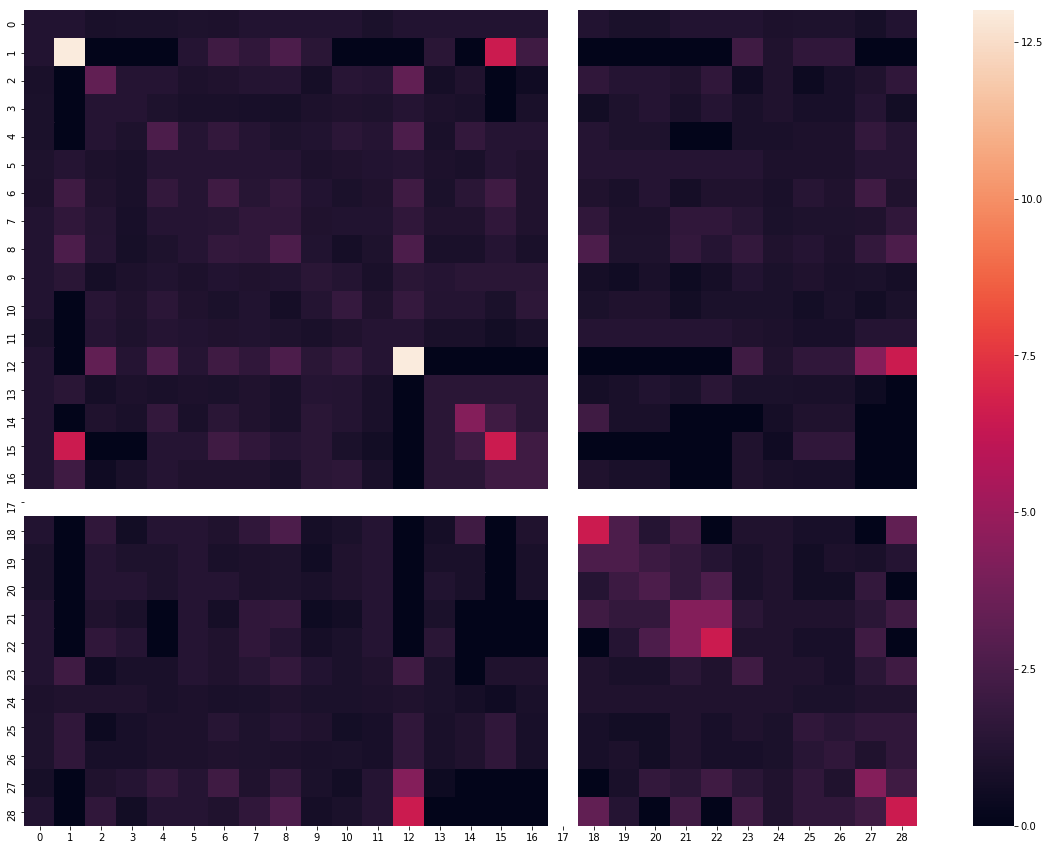

In [5]:
##Part 1: Make the matrix P(Senti and sent j)/(P(Senti) * P(Sentj))

#make the empty sentence x sentence matrix
norm_dep_matrix = np.zeros((n_sent,n_sent))

subj, sents = subj_sent_m.shape

for i in range(sents):
    for j in range(sents):
        first_prob = np.sum(subj_sent_m[:, i])/subj
        second_prob = np.sum(subj_sent_m[:, j])/subj
        ##test
        if i == 1 and j == 1:
            print(first_prob, second_prob)
        count = 0
        for k in range(subj):
            if subj_sent_m[k, i] == 1:
                if subj_sent_m[k, j] == 1:
                    count += 1
        first_second_prob = count/subj
        ##test
        if i == 1 and j == 1:
            print(first_second_prob)
            print(first_second_prob/(first_prob * second_prob))
        norm_dep_matrix[i, j] = first_second_prob/(first_prob * second_prob)
        
plt.subplots(figsize=(20,15))
heatmap = sb.heatmap(norm_dep_matrix)
#heatmap = sb.heatmap(dep_matrix, vmin=0, vmax=2)
plt.show()

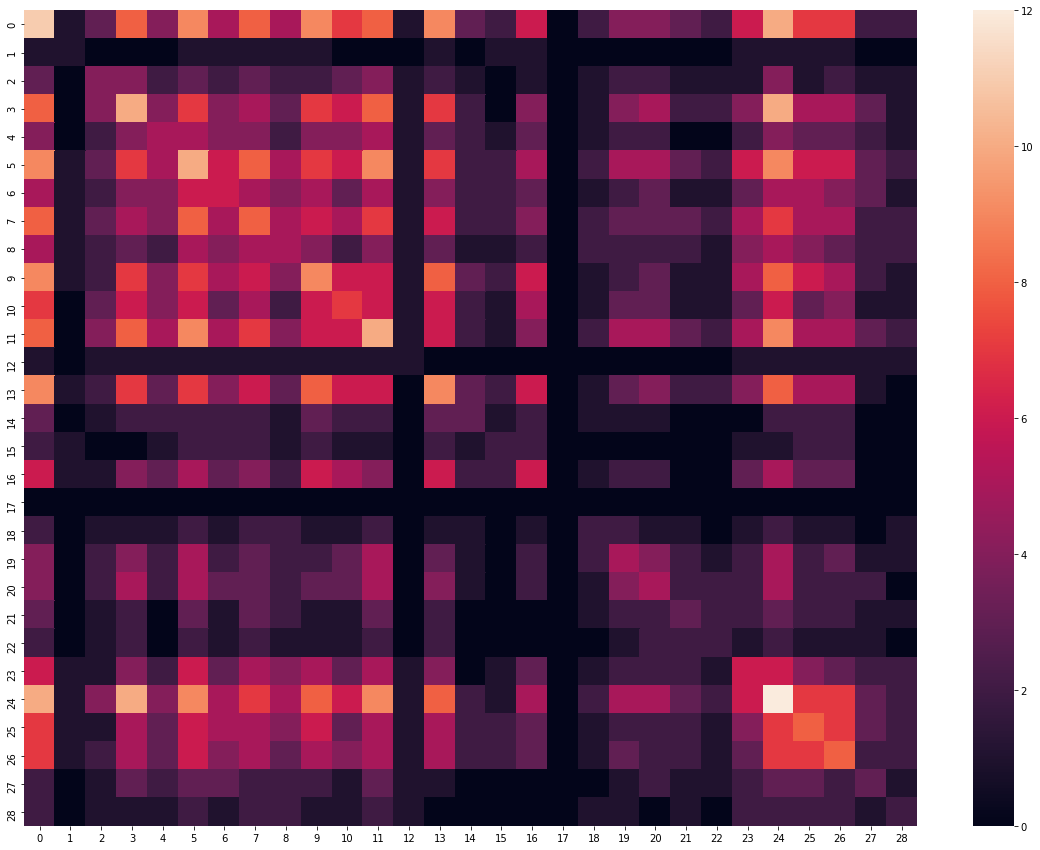

In [6]:
##Part 2: Make the matrix of just the counts of co occurrences of sentence mentions

#make the empty sentence x sentence matrix
dep_matrix = np.zeros((sents,sents))

for i in range(sents):
    for j in range(sents):
        count = 0
        for k in range(subj):
            if subj_sent_m[k, i] == 1:
                if subj_sent_m[k, j] == 1:
                    count += 1
        first_second_cooccurrence_sum = count
        dep_matrix[i, j] = first_second_cooccurrence_sum
        
plt.subplots(figsize=(20,15))
heatmap = sb.heatmap(dep_matrix)
plt.show()

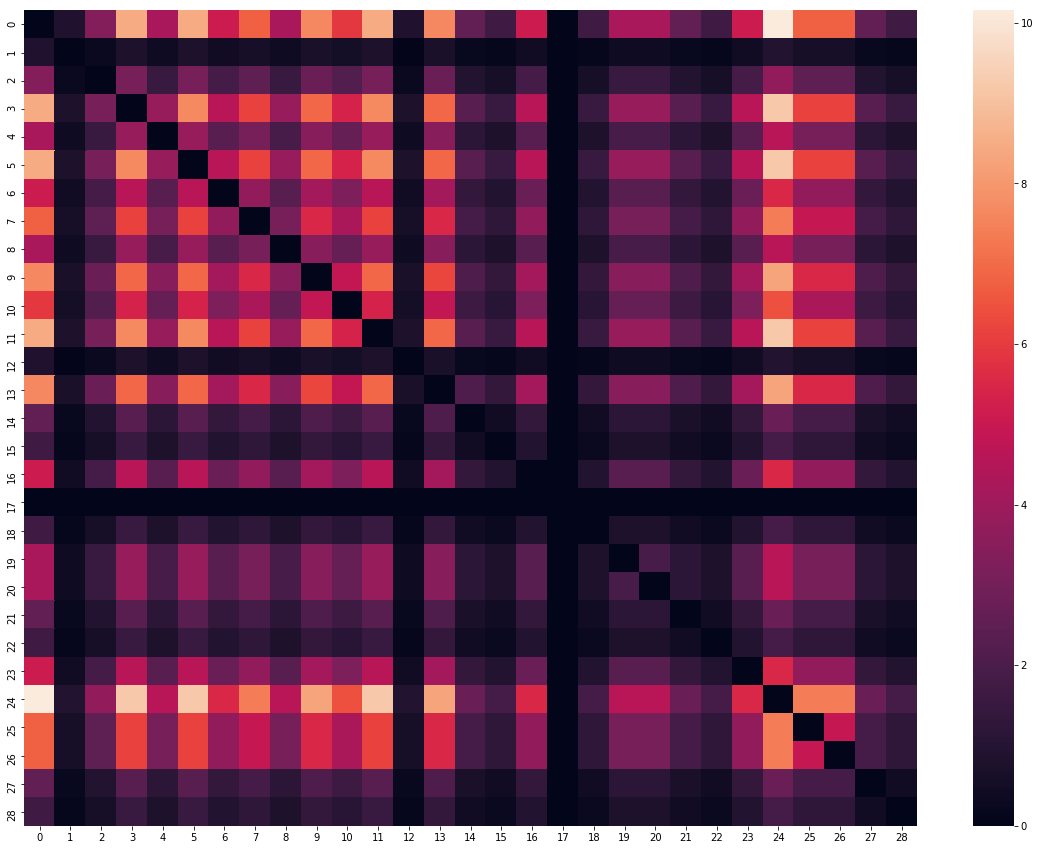

In [7]:
##Part 3: Create the null dependency matrix where null_dep_matrix[i,j] = dep_matrix[i,i] * dep_matrix[j,j]

null_dep_matrix = np.zeros((sents, sents))
for i in range(sents):
    for j in range(i+1, sents):
        ##why am i dividing by subjects?
        null_dep_matrix[i,j] = subj*dep_matrix[i,i]/subj * dep_matrix[j,j]/subj
null_dep_matrix = null_dep_matrix + null_dep_matrix.T
plt.subplots(figsize=(20,15))
heatmap = sb.heatmap(null_dep_matrix)
plt.show()

# II: Social Primed Participants
## Step 1: Matrices
### Part 1: Participant x story sentence matrix
### Part 2: Co-occurence matrix
### Part 3: Null Dependency matrix
### Part 4: Exporting matrices to excel and printing Dict
## Step 2: Parsing into Social Events
### Part 1: Determining the story sentences that define the social events
### Part 2: Summing the number of co-occurences within each event for the co-occurence and null dependency matrix
###### Output: Dict = {event#: [[event start, event end, co-occurence sum, null dep sum]]}
### Part 3: Within-event and Extra-event values
### Part 4: Average co-occurrences within-event and extra-event
## Step 3: Parsing into Location Events
### Part 1: Determining the story sentences that define the location events
### Part 2: Summing the number of co-occurences within each event for the co-occurence and null dependency matrix
### Part 3: Within-event and Extra-event values
### Part 4: Average co-occurrences within-event and extra-event

## Step 1: Matrices

In [8]:
#Part 1: make a participant x story sentence matrix with '1' values for sentences that that 
#participant mentioned in their free recall for social primed participants

#find the number of sentences in story 43
n_sent = story_stats['43'][3]

#the number of social primed participants
n_social = (sum( x == 'Social' for x in subj_schemas['43'].values()))

#make empty participant x story sentences matrix
soc_subj_sent_m = np.zeros((n_social, n_sent))
count = 0
for name in sheet_names:
    if subj_schemas['43'][name] == 'Social':
        for i in range(n_sent):
            val = np.sum(rs_dict[name][i+1])
            if val > 0:
                val = 1
            soc_subj_sent_m[count, i] = val
        count += 1

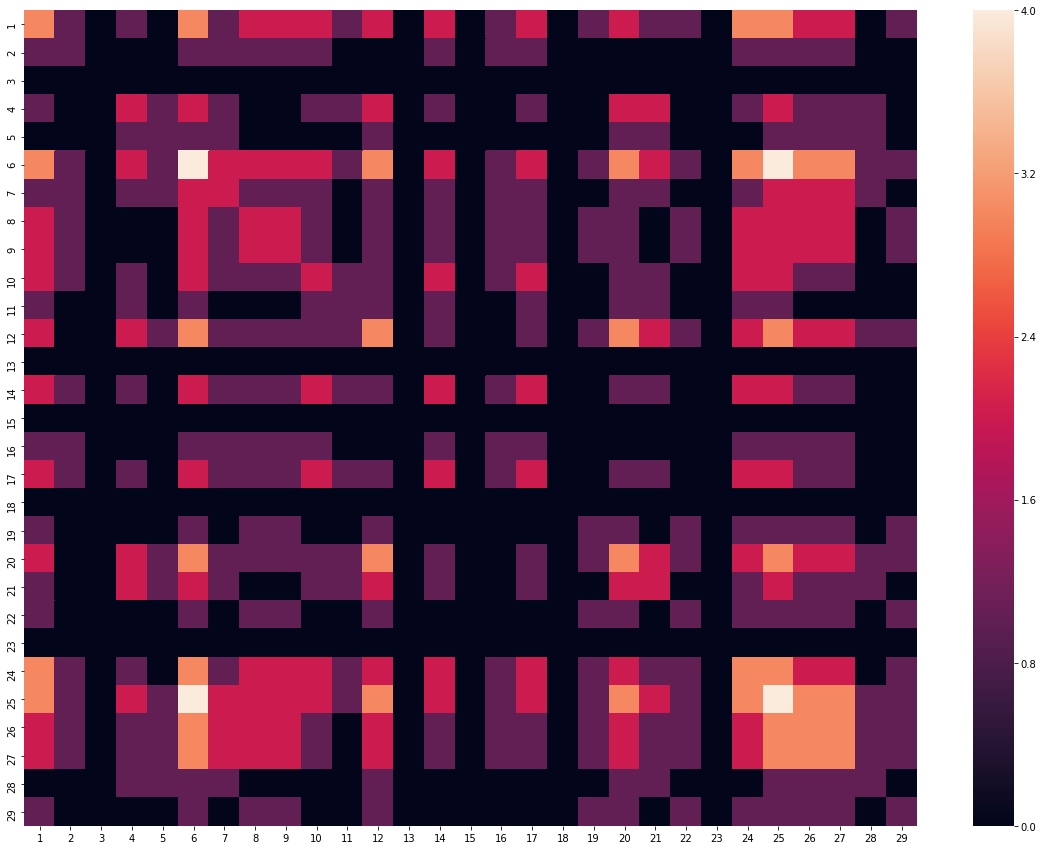

In [9]:
#Part 2: Make the co occurrence count matrix  of social primed participants

#make the empty sentence x sentence matrix
soc_dep_matrix = np.zeros((sents,sents))

for i in range(sents):
    for j in range(sents):
        count = 0
        for k in range(n_social):
            if soc_subj_sent_m[k, i] == 1:
                if soc_subj_sent_m[k, j] == 1:
                    count += 1
        soc_dep_matrix[i, j] = count

#convert np array to dataframe with correctly labeled sentences        
index = list(range(1, sents+1))
df_soc_dep_matrix = pd.DataFrame(data=soc_dep_matrix, index=index, columns= index)
        
plt.subplots(figsize=(20,15))
heatmap = sb.heatmap(df_soc_dep_matrix)
plt.show()

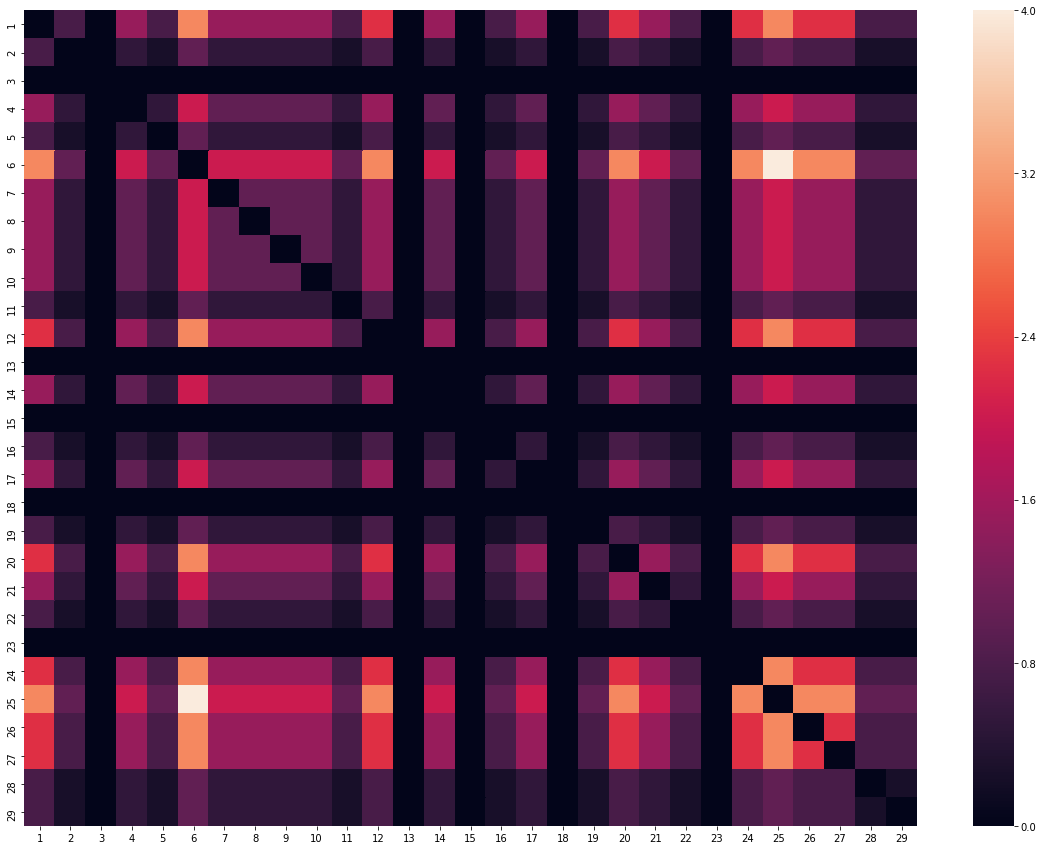

In [10]:
#Part 3: Make the null dependency matrix for social primed responses
soc_null_dep_matrix = np.zeros((sents, sents))
for i in range(sents):
    for j in range(i+1, sents):
        soc_null_dep_matrix[i,j] = soc_dep_matrix[i,i] * soc_dep_matrix[j,j]/n_social
soc_null_dep_matrix = soc_null_dep_matrix + soc_null_dep_matrix.T

#convert to pd to correctly label axes
df_soc_null_dep_matrix = pd.DataFrame(data=soc_null_dep_matrix, index=index, columns= index)
plt.subplots(figsize=(20,15))
heatmap = sb.heatmap(df_soc_null_dep_matrix)
plt.show()

In [11]:
# Part 4: Exporting matrices to excel files
df_soc_dep_matrix.to_excel("soc_dep_matrix.xlsx")
df_soc_null_dep_matrix.to_excel("soc_null_dep_matrix.xlsx")

## Step 2: Parsing into Social Events

In [12]:
# Part 1: find the story sentences that mark the boundaries of each social event
SP_soc_event = {}

#make the dictionary of all the events
for i in range(1,5):
    SP_soc_event[i] = np.zeros((1,5))

count = 1
for j in range(len(story_boundaries['43'])):
    if story_boundaries['43'][j, 1] == 1:
        if count == 1:
            SP_soc_event[count][0,0] = 1
            count = 2
        else:
            SP_soc_event[count-1][0,1] = j
            SP_soc_event[count][0,0] = j+1
            count += 1
        
SP_soc_event[4][0,1] = len(story_boundaries['43']) 

In [13]:
# Part 2:  Summing the number of co-occurences within each event for the co-occurence and null 
#dependency matrix
#output: Dict = {event#: [[event start, event end, co-occurence sum, null dep sum]]}

for i in range(1,5):
    x, y, z, a,b = SP_soc_event[i][0]
    soc_sum = 0
    null_soc_sum = 0
    #get the total number of sentence comparisons for each event
    count_comp = 0
    for m in range(int(x), int(y + 1)):
        for n in range(int(x), int(y + 1)):
            if m == n:
                continue
            else:
                count_comp += 1
                soc_sum += df_soc_dep_matrix.loc[m,n]
                null_soc_sum += df_soc_null_dep_matrix.loc[m,n]
    #dividing by 2 bc the top and the bottom half of the matrix are the same
    SP_soc_event[i][0,2] = soc_sum/2
    SP_soc_event[i][0,3] = null_soc_sum/2 
    SP_soc_event[i][0,4] = count_comp/2

In [14]:
# Part 3: Within-event and extra-event values
#output : primingtype_eventboundarytype_WE = [W1, W2, W3; E1, E2, E3]

SP_social_WE = np.zeros((2,3))

#find W1 and W2, the sums of the co-occurences in events for the co-occurence matrix
#and the null dependency matrix

W1 = 0
W2 = 0

for i in range(1,5):
    W1 += SP_soc_event[i][0, 2]
    W2 += SP_soc_event[i][0,3]

#W3- the ratio of W1 and W2
W3 = W1/W2

#E1, E2
extra_indices = np.ones((sents, sents))
extra_indices = np.triu(extra_indices, k = 1)

#removing from extra_indices where there are sentence comparisons within an event
for i in range(1,5):
    x, y, z, a,b = SP_soc_event[i][0]
    for m in range(int(x), int(y + 1)):
        for n in range(int(x), int(y + 1)):
            if m == n:
                continue
            else:
                extra_indices[m-1, n-1] = 0

#E1
np_soc_dep_matrix = df_soc_dep_matrix.to_numpy()
extra_co_occurrences_matrix = np_soc_dep_matrix * extra_indices
E1 = np.sum(extra_co_occurrences_matrix, axis = None)

#E2
np_soc_null_dep_matrix = df_soc_null_dep_matrix.to_numpy()
extra_null_matrix = np_soc_null_dep_matrix * extra_indices
E2 = np.sum(extra_null_matrix, axis = None)
          
#E3
E3 = E1/E2

SP_social_WE = np.array([[W1, W2, W3], [E1, E2, E3]])

SP_social_WE

array([[ 73.        ,  75.5       ,   0.96688742],
       [217.        , 221.25      ,   0.98079096]])

In [16]:
# Part 4: Average co-occurrences within-event and extra-event

#total number of within-event sentence comparisons
total_within = 0
for i in range(1,5):
    total_within += SP_soc_event[i][0,4]

#total number of extra-event sentence comparisons
total_extra = np.count_nonzero(extra_indices)

#make matrix of avg Within- and extra-event values
avg_SP_social_WE = np.zeros((2,3))
avg_SP_social_WE[0, 0] = W1/total_within
avg_SP_social_WE[0, 1] = W2/total_within
avg_SP_social_WE[0, 2] = avg_SP_social_WE[0, 0]/avg_SP_social_WE[0, 1]

avg_SP_social_WE[1, 0] = E1/total_extra
avg_SP_social_WE[1, 1] = E2/total_extra
avg_SP_social_WE[1, 2] = avg_SP_social_WE[1, 0]/avg_SP_social_WE[1, 1]

avg_SP_social_WE

array([[0.66363636, 0.68636364, 0.96688742],
       [0.73310811, 0.74746622, 0.98079096]])

## Step 3: Parsing into Location Events

In [17]:
# Part 1: Determining the story sentences that define the location events
SP_loc_event = {}

#make the dictionary of all the events
for i in range(1,5):
    SP_loc_event[i] = np.zeros((1,5))

count = 1
for j in range(len(story_boundaries['43'])):
    if story_boundaries['43'][j, 0] == 1:
        if count == 1:
            SP_loc_event[count][0,0] = 1
            count = 2
        else:
            SP_loc_event[count-1][0,1] = j
            SP_loc_event[count][0,0] = j+1
            count += 1
        
SP_loc_event[4][0,1] = len(story_boundaries['43']) 

In [18]:
# Part 2: Summing the number of co-occurences within each event for the co-occurence and
#null dependency matrix

for i in range(1,5):
    x, y, z, a, b = SP_loc_event[i][0]
    soc_sum = 0
    null_soc_sum = 0
    count_comp = 0
    for m in range(int(x), int(y + 1)):
        for n in range(int(x), int(y + 1)):
            if m == n:
                continue
            else:
                count_comp += 1
                soc_sum += df_soc_dep_matrix.loc[m,n]
                null_soc_sum += df_soc_null_dep_matrix.loc[m,n]
    #dividing by 2 bc the top and the bottom half of the matrix are the same
    ##ask Chris
    SP_loc_event[i][0,2] = soc_sum/2
    SP_loc_event[i][0,3] = null_soc_sum/2
    SP_loc_event[i][0,4] = count_comp/2

In [19]:
# Part 3: Within-event and extra-event values
#output : primingtype_eventboundarytype_WE = [W1, W2, W3; E1, E2, E3]

SP_location_WE = np.zeros((2,3))

#find W1 and W2, the sums of the co-occurences in events for the co-occurence matrix
#and the null dependency matrix

W1 = 0
W2 = 0

for i in range(1,5):
    W1 += SP_loc_event[i][0, 2]
    W2 += SP_loc_event[i][0,3]

#W3- the ratio of W1 and W2
W3 = W1/W2

#E1, E2
extra_indices = np.ones((sents, sents))
extra_indices = np.triu(extra_indices, k = 1)

#removing from extra_indices where there are sentence comparisons within an event
for i in range(1,5):
    x, y, z, a, b = SP_loc_event[i][0]
    for m in range(int(x), int(y + 1)):
        for n in range(int(x), int(y + 1)):
            if m == n:
                continue
            else:
                extra_indices[m-1, n-1] = 0

#E1
np_soc_dep_matrix = df_soc_dep_matrix.to_numpy()
extra_co_occurrences_matrix = np_soc_dep_matrix * extra_indices
E1 = np.sum(extra_co_occurrences_matrix, axis = None)

#E2
np_soc_null_dep_matrix = df_soc_null_dep_matrix.to_numpy()
extra_null_matrix = np_soc_null_dep_matrix * extra_indices
E2 = np.sum(extra_null_matrix, axis = None)
          
#E3
E3 = E1/E2

SP_location_WE = np.array([[W1, W2, W3], [E1, E2, E3]])

SP_location_WE

array([[ 87.        ,  86.75      ,   1.00288184],
       [203.        , 210.        ,   0.96666667]])

In [20]:
# Part 4: Average co-occurrences within-event and extra-event

#total number of within-event sentence comparisons
total_within = 0
for i in range(1,5):
    total_within += SP_loc_event[i][0,4]

#total number of extra-event sentence comparisons
total_extra = np.count_nonzero(extra_indices)

#make matrix of avg Within- and extra-event values
avg_SP_location_WE = np.zeros((2,3))
avg_SP_location_WE[0, 0] = W1/total_within
avg_SP_location_WE[0, 1] = W2/total_within
avg_SP_location_WE[0, 2] = avg_SP_location_WE[0, 0]/avg_SP_location_WE[0, 1]

avg_SP_location_WE[1, 0] = E1/total_extra
avg_SP_location_WE[1, 1] = E2/total_extra
avg_SP_location_WE[1, 2] = avg_SP_location_WE[1, 0]/avg_SP_location_WE[1, 1]

avg_SP_location_WE

array([[0.81308411, 0.81074766, 1.00288184],
       [0.67892977, 0.70234114, 0.96666667]])

# III: Location-primed participants
### Step 1: Matrices
#### Part 1: Participant x story sentence matrix
#### Part 2: Co-occurence matrix
#### Part 3: Null Dependency matrix
#### Part 4: Exporting Matrices as Excel files
### Step 2: Parsing into Social Events
#### Part 1: Determining the story sentences that define the social events
#### Part 2: Summing the number of co-occurences within each event for the co-occurence and null dependency matrix
###### Output: Dict = {event#: [[event start, event end, co-occurence sum, null dep sum]]}
#### Part 3: Within-event and Extra-event values
### Step 3: Parsing into Location Events
#### Part 1: Determining the story sentences that define the location events
#### Part 2: Summing the number of co-occurences within each event for the co-occurence and null dependency matrix
#### Part 3: Within-event and Extra-event values

## Step 1: Matrices

In [21]:
# Part 1: Participant x story sentence matrix

#find the number of sentences in story 43
n_sent = story_stats['43'][3]

#the number of social primed participants
n_location = (sum( x == 'Location' for x in subj_schemas['43'].values()))

#make empty participant x story sentences matrix
loc_subj_sent_m = np.zeros((n_location, n_sent))
count = 0
for name in sheet_names:
    if subj_schemas['43'][name] == 'Location':
        for i in range(n_sent):
            val = np.sum(rs_dict[name][i+1])
            if val > 0:
                val = 1
            loc_subj_sent_m[count, i] = val
        count += 1

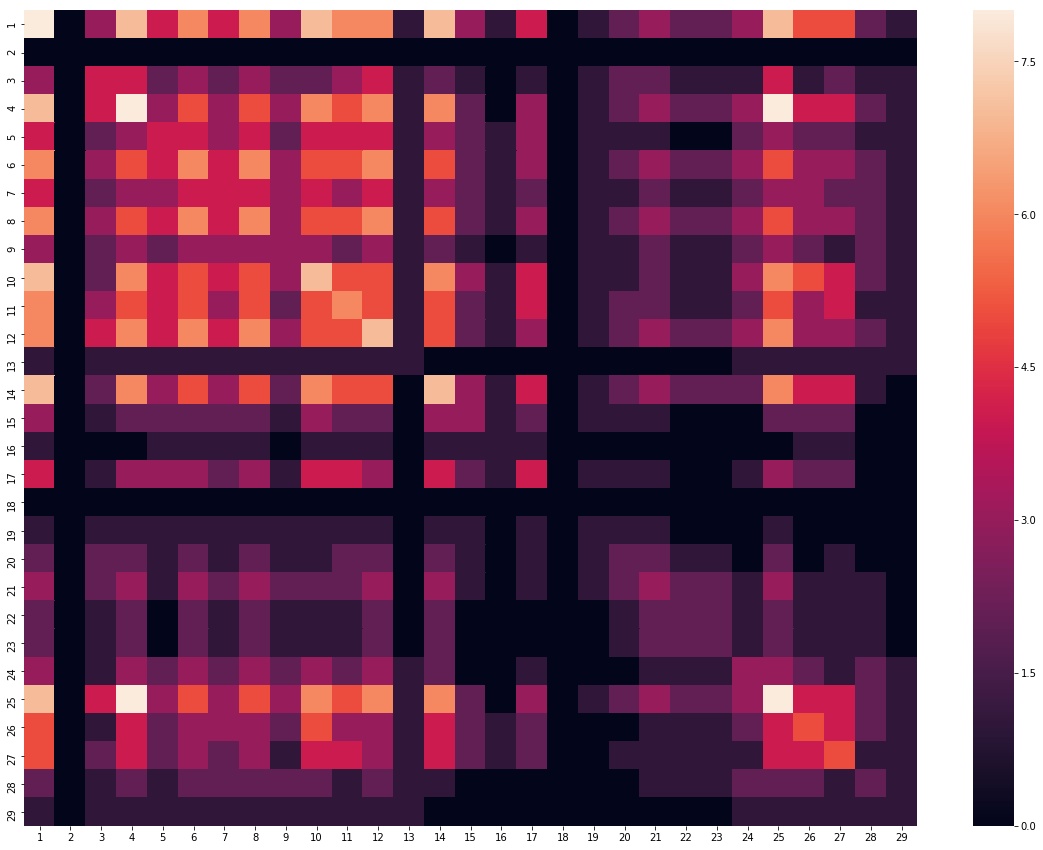

In [22]:
# Part 2: Co-occurence matrix

#make the empty sentence x sentence matrix
loc_dep_matrix = np.zeros((sents,sents))

for i in range(sents):
    for j in range(sents):
        count = 0
        for k in range(n_location):
            if loc_subj_sent_m[k, i] == 1:
                if loc_subj_sent_m[k, j] == 1:
                    count += 1
        loc_dep_matrix[i, j] = count

#convert np array to dataframe with correctly labeled sentences        
index = list(range(1, sents+1))
df_loc_dep_matrix = pd.DataFrame(data=loc_dep_matrix, index=index, columns= index)
        
plt.subplots(figsize=(20,15))
heatmap = sb.heatmap(df_loc_dep_matrix)
plt.show()

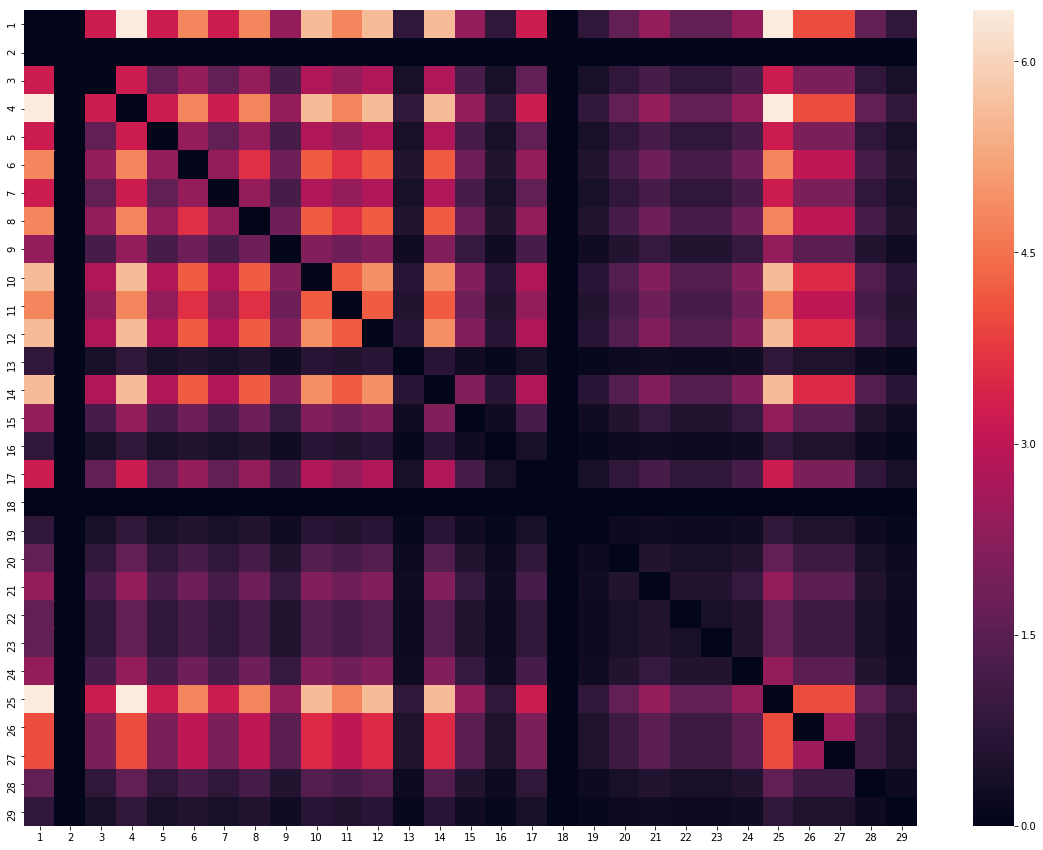

In [23]:
# Part 3: Null Dependency matrix

loc_null_dep_matrix = np.zeros((sents, sents))
for i in range(sents):
    for j in range(i+1, sents):
        loc_null_dep_matrix[i,j] = loc_dep_matrix[i,i] * loc_dep_matrix[j,j]/n_location
loc_null_dep_matrix = loc_null_dep_matrix + loc_null_dep_matrix.T

#convert to pd to correctly label axes
df_loc_null_dep_matrix = pd.DataFrame(data=loc_null_dep_matrix, index=index, columns= index)
plt.subplots(figsize=(20,15))
heatmap = sb.heatmap(df_loc_null_dep_matrix)
plt.show()

In [24]:
# Part 4: Exporting Matrices as Excel files
df_loc_dep_matrix.to_excel("loc_dep_matrix.xlsx")
df_loc_null_dep_matrix.to_excel("loc_null_dep_matrix.xlsx")

## Step 2: Parsing into Social Events

In [25]:
# Part 1: Determining the story sentences that define the social events

LP_soc_event = {}

#make the dictionary of all the events
for i in range(1,5):
    LP_soc_event[i] = np.zeros((1,5))

count = 1
for j in range(len(story_boundaries['43'])):
    if story_boundaries['43'][j, 1] == 1:
        if count == 1:
            LP_soc_event[count][0,0] = 1
            count = 2
        else:
            LP_soc_event[count-1][0,1] = j
            LP_soc_event[count][0,0] = j+1
            count += 1
        
LP_soc_event[4][0,1] = len(story_boundaries['43']) 

In [26]:
# Part 2: Summing the number of co-occurences within each event 
# for the co-occurence and null dependency matrix

for i in range(1,5):
    x, y, z, a, b = LP_soc_event[i][0]
    loc_sum = 0
    null_loc_sum = 0
    count_comp = 0
    for m in range(int(x), int(y + 1)):
        for n in range(int(x), int(y + 1)):
            if m == n:
                continue
            else:
                count_comp += 1
                loc_sum += df_loc_dep_matrix.loc[m,n]
                null_loc_sum += df_loc_null_dep_matrix.loc[m,n]
    #dividing by 2 bc the top and the bottom half of the matrix are the same
    ##ask Chris
    LP_soc_event[i][0,2] = loc_sum/2
    LP_soc_event[i][0,3] = null_loc_sum/2  
    LP_soc_event[i][0,4] = count_comp/2

In [27]:
# Part 3: Within-event and extra-event values
#output : primingtype_eventboundarytype_WE = [W1, W2, W3; E1, E2, E3]

LP_social_WE = np.zeros((2,3))

#find W1 and W2, the sums of the co-occurences in events for the co-occurence matrix
#and the null dependency matrix

W1 = 0
W2 = 0

for i in range(1,5):
    W1 += LP_soc_event[i][0, 2]
    W2 += LP_soc_event[i][0,3]

#W3- the ratio of W1 and W2
W3 = W1/W2

#E1, E2
extra_indices = np.ones((sents, sents))
extra_indices = np.triu(extra_indices, k = 1)

#removing from extra_indices where there are sentence comparisons within an event
for i in range(1,5):
    x, y, z, a,b = LP_soc_event[i][0]
    for m in range(int(x), int(y + 1)):
        for n in range(int(x), int(y + 1)):
            if m == n:
                continue
            else:
                extra_indices[m-1, n-1] = 0

#E1
np_loc_dep_matrix = df_loc_dep_matrix.to_numpy()
extra_co_occurrences_matrix = np_loc_dep_matrix * extra_indices
E1 = np.sum(extra_co_occurrences_matrix, axis = None)

#E2
np_loc_null_dep_matrix = df_loc_null_dep_matrix.to_numpy()
extra_null_matrix = np_loc_null_dep_matrix * extra_indices
E2 = np.sum(extra_null_matrix, axis = None)
          
#E3
E3 = E1/E2

LP_social_WE = np.array([[W1, W2, W3], [E1, E2, E3]])

LP_social_WE

array([[199.        , 151.2       ,   1.31613757],
       [545.        , 456.4       ,   1.19412796]])

In [29]:
# Part 4: Average co-occurrences within-event and extra-event

#total number of within-event sentence comparisons
total_within = 0
for i in range(1,5):
    total_within += LP_soc_event[i][0,4]

#total number of extra-event sentence comparisons
total_extra = np.count_nonzero(extra_indices)

#make matrix of avg Within- and extra-event values
avg_LP_social_WE = np.zeros((2,3))
avg_LP_social_WE[0, 0] = W1/total_within
avg_LP_social_WE[0, 1] = W2/total_within
avg_LP_social_WE[0, 2] = avg_LP_social_WE[0, 0]/avg_LP_social_WE[0, 1]

avg_LP_social_WE[1, 0] = E1/total_extra
avg_LP_social_WE[1, 1] = E2/total_extra
avg_LP_social_WE[1, 2] = avg_LP_social_WE[1, 0]/avg_LP_social_WE[1, 1]

avg_LP_social_WE

array([[1.80909091, 1.37454545, 1.31613757],
       [1.84121622, 1.54189189, 1.19412796]])

## Step 3: Parsing into Location Events

In [30]:
# Part 1: Determining the story sentences that define the location events

LP_loc_event = {}

#make the dictionary of all the events
for i in range(1,5):
    LP_loc_event[i] = np.zeros((1,5))

count = 1
for j in range(len(story_boundaries['43'])):
    if story_boundaries['43'][j, 0] == 1:
        if count == 1:
            LP_loc_event[count][0,0] = 1
            count = 2
        else:
            LP_loc_event[count-1][0,1] = j
            LP_loc_event[count][0,0] = j+1
            count += 1
        
LP_loc_event[4][0,1] = len(story_boundaries['43']) 

In [31]:
# Part 2: Summing the number of co-occurences within each event for the 
#co-occurence and null dependency matrix

for i in range(1,5):
    x, y, z, a, b = LP_loc_event[i][0]
    loc_sum = 0
    null_loc_sum = 0
    count_comp = 0
    for m in range(int(x), int(y + 1)):
        for n in range(int(x), int(y + 1)):
            if m == n:
                continue
            else:
                count_comp += 1
                loc_sum += df_loc_dep_matrix.loc[m,n]
                null_loc_sum += df_loc_null_dep_matrix.loc[m,n]
    #dividing by 2 bc the top and the bottom half of the matrix are the same
    ##ask Chris
    LP_loc_event[i][0,2] = loc_sum/2
    LP_loc_event[i][0,3] = null_loc_sum/2
    LP_loc_event[i][0,4] = count_comp/2

In [32]:
# Part 3: Within-event and Extra-event co-occurrences

#output : primingtype_eventboundarytype_WE = [W1, W2, W3; E1, E2, E3]

#find W1 and W2, the sums of the co-occurences in events for the co-occurence matrix
#and the null dependency matrix

W1 = 0
W2 = 0

for i in range(1,5):
    W1 += LP_loc_event[i][0, 2]
    W2 += LP_loc_event[i][0,3]

#W3- the ratio of W1 and W2
W3 = W1/W2

#E1, E2
extra_indices = np.ones((sents, sents))
extra_indices = np.triu(extra_indices, k = 1)

#removing from extra_indices where there are sentence comparisons within an event
for i in range(1,5):
    x, y, z, a, b = LP_loc_event[i][0]
    for m in range(int(x), int(y + 1)):
        for n in range(int(x), int(y + 1)):
            if m == n:
                continue
            else:
                extra_indices[m-1, n-1] = 0


#Top half of the co-occurence and null-dependency matrix
iu = np.triu_indices(sents, 1)

#Subtracting the sentence comparisons that are in an event
E1 = sum(df_loc_dep_matrix.values[iu]) - W1
E2 = sum(df_loc_null_dep_matrix.values[iu]) - W2
E3 = E1/E2

LP_location_WE = np.array([[W1, W2, W3], [E1, E2, E3]])

LP_location_WE

array([[203.        , 157.4       ,   1.28970775],
       [541.        , 450.2       ,   1.20168814]])

In [33]:
# Part 4: Average co-occurrences within-event and extra-event

#total number of within-event sentence comparisons
total_within = 0
for i in range(1,5):
    total_within += LP_loc_event[i][0,4]

#total number of extra-event sentence comparisons
total_extra = np.count_nonzero(extra_indices)

#make matrix of avg Within- and extra-event values
avg_LP_location_WE = np.zeros((2,3))
avg_LP_location_WE[0, 0] = W1/total_within
avg_LP_location_WE[0, 1] = W2/total_within
avg_LP_location_WE[0, 2] = avg_LP_location_WE[0, 0]/avg_LP_location_WE[0, 1]

avg_LP_location_WE[1, 0] = E1/total_extra
avg_LP_location_WE[1, 1] = E2/total_extra
avg_LP_location_WE[1, 2] = avg_LP_location_WE[1, 0]/avg_LP_location_WE[1, 1]

avg_LP_location_WE

array([[1.89719626, 1.47102804, 1.28970775],
       [1.80936455, 1.50568562, 1.20168814]])

# IV: Graphing
## Step 1: Co-occurence counts divided into individual events
### Part 1: Social-primed participants
### Part 2: Location-primed participants
## Step 2: Within-event and Extra-event Sums/Raw and Average
### Part 1: Social-primed participants
### Part 2: Location-primed participants


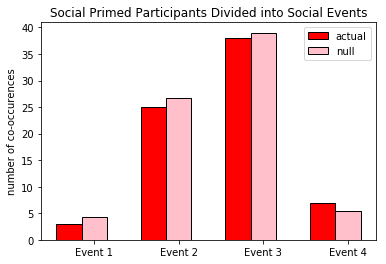

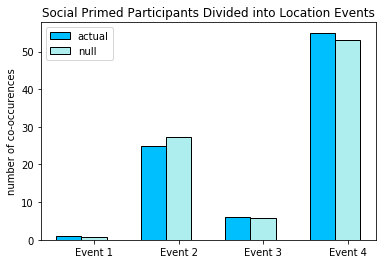

In [34]:
#Step 1: Co-occurence counts divided into individual events
#Part 1: Social Primed Participants
#input: SP_soc_event, SP_loc_event

# width of the bars
barWidth = 0.3
 
#SP_soc_event
bars1 = []
for i in range(1,5):
    bars1.append(SP_soc_event[i][0,2])
 
bars2 = []
for i in range(1, 5):
    bars2.append(SP_soc_event[i][0,3])
    
#SP_loc_event
bars3 = []
for i in range(1,5):
    bars3.append(SP_loc_event[i][0,2])
 
bars4 = []
for i in range(1, 5):
    bars4.append(SP_loc_event[i][0,3])
    


#SP_soc_event
# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = 'red', edgecolor = 'black', label='actual')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = 'pink', edgecolor = 'black', label='null')
 
# general layout
plt.xticks([r + barWidth for r in range(len(bars1))], ['Event 1', 'Event 2', 'Event 3', 'Event 4'])
plt.ylabel('number of co-occurences')
plt.legend()
plt.title('Social Primed Participants Divided into Social Events')
 
# Show graphic
plt.show()

plt.figure()

#SP_loc_event

# Create blue bars
plt.bar(r1, bars3, width = barWidth, color = 'deepskyblue', edgecolor = 'black', label='actual')
 
# Create cyan bars
plt.bar(r2, bars4, width = barWidth, color = 'paleturquoise', edgecolor = 'black', label='null')
 
# general layout
plt.xticks([r + barWidth for r in range(len(bars1))], ['Event 1', 'Event 2', 'Event 3', 'Event 4'])
plt.ylabel('number of co-occurences')
plt.legend()
plt.title('Social Primed Participants Divided into Location Events')
 
# Show graphic
plt.show()

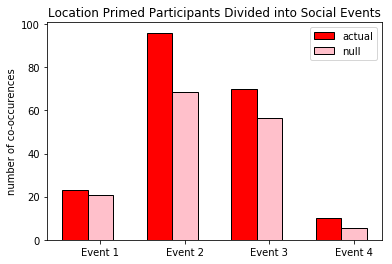

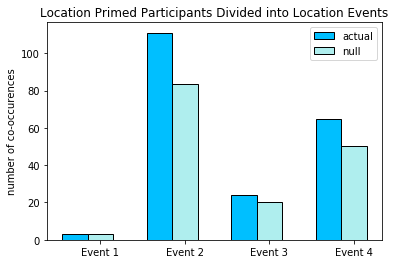

In [35]:
#Step 1: Co-occurence counts broken into social Events and Location Events
#Part 1: Location Primed Participants
#input: LP_soc_event, LP_loc_event

# width of the bars
barWidth = 0.3
 
#SP_soc_event
bars1 = []
for i in range(1,5):
    bars1.append(LP_soc_event[i][0,2])
 
bars2 = []
for i in range(1, 5):
    bars2.append(LP_soc_event[i][0,3])
    
#SP_loc_event
bars3 = []
for i in range(1,5):
    bars3.append(LP_loc_event[i][0,2])
 
bars4 = []
for i in range(1, 5):
    bars4.append(LP_loc_event[i][0,3])
    


#SP_soc_event
# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = 'red', edgecolor = 'black', label='actual')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = 'pink', edgecolor = 'black', label='null')
 
# general layout
plt.xticks([r + barWidth for r in range(len(bars1))], ['Event 1', 'Event 2', 'Event 3', 'Event 4'])
plt.ylabel('number of co-occurences')
plt.legend()
plt.title('Location Primed Participants Divided into Social Events')
 
# Show graphic
plt.show()

plt.figure()

#SP_loc_event

# Create blue bars
plt.bar(r1, bars3, width = barWidth, color = 'deepskyblue', edgecolor = 'black', label='actual')
 
# Create cyan bars
plt.bar(r2, bars4, width = barWidth, color = 'paleturquoise', edgecolor = 'black', label='null')
 
# general layout
plt.xticks([r + barWidth for r in range(len(bars1))], ['Event 1', 'Event 2', 'Event 3', 'Event 4'])
plt.ylabel('number of co-occurences')
plt.legend()
plt.title('Location Primed Participants Divided into Location Events')
 
# Show graphic
plt.show()

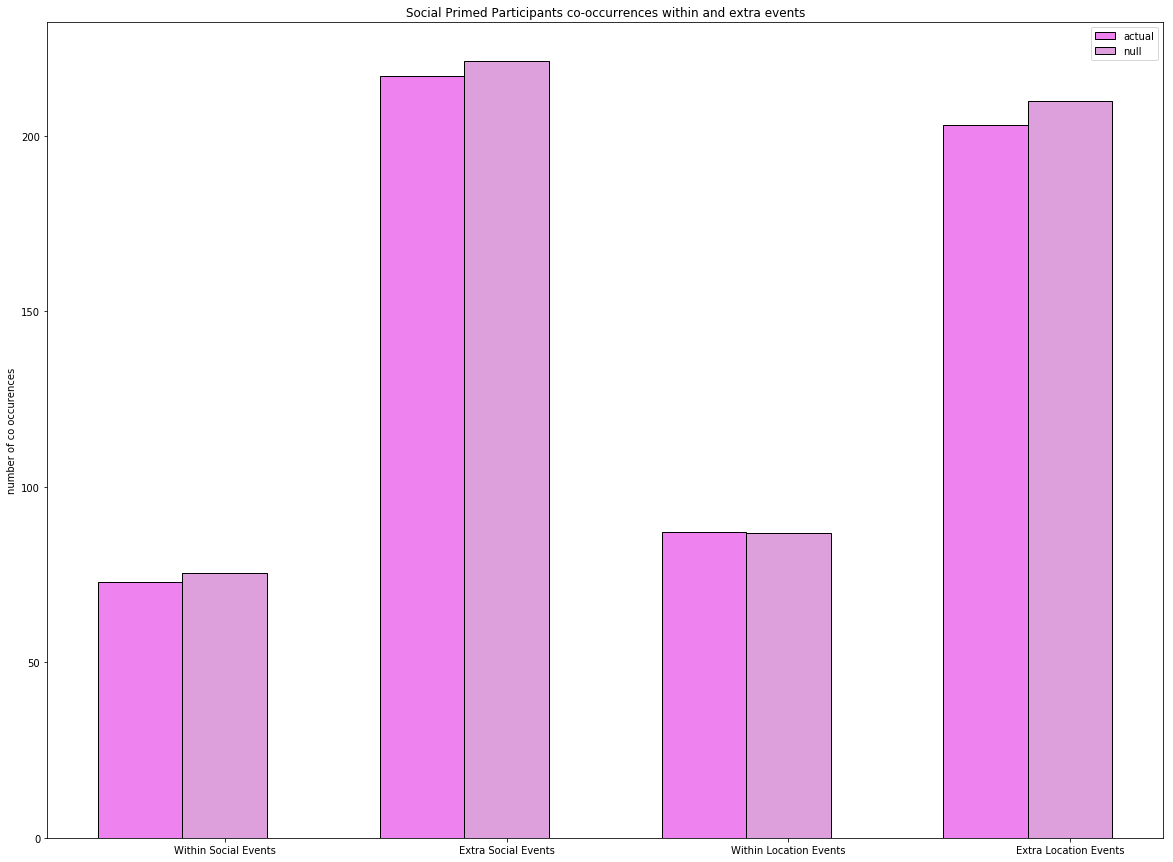

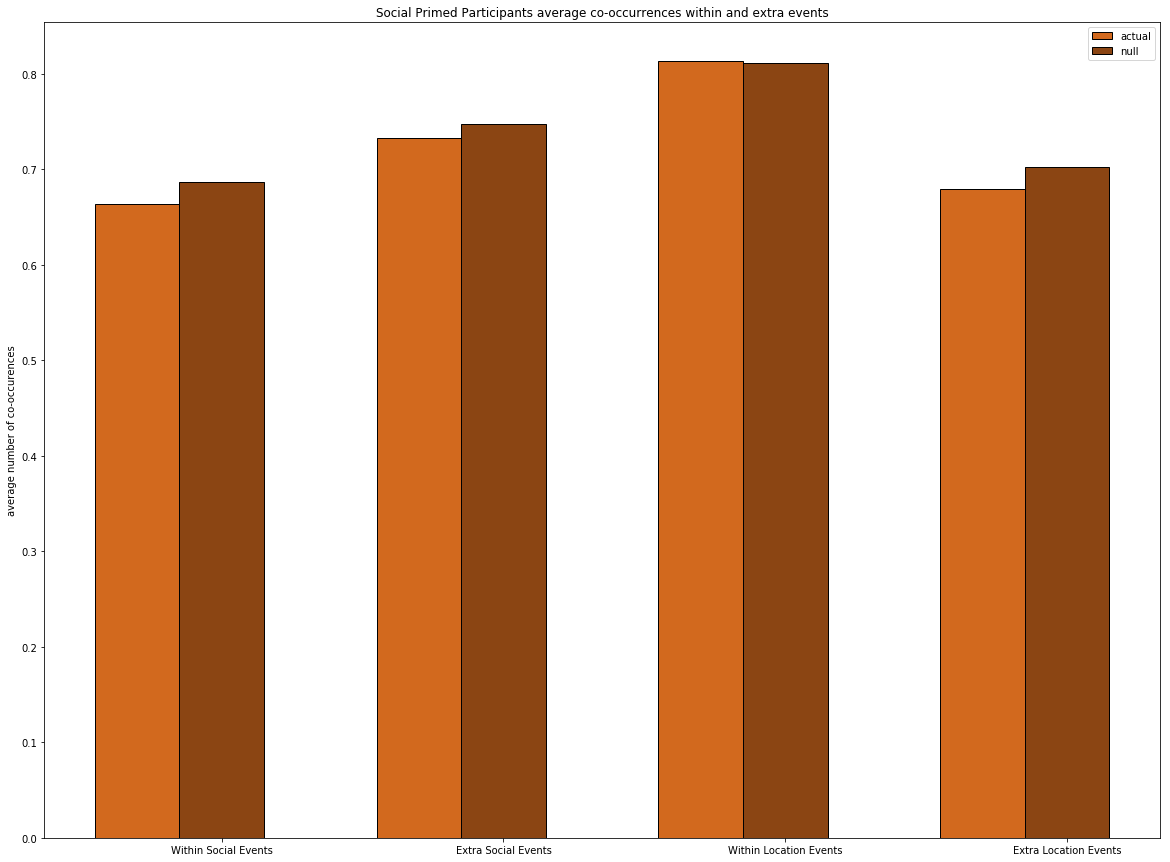

In [36]:
# Step 2: Within-event and Extra-event Sums/ Raw and Averages
# Part 1: Social-primed participants
# width of the bars
barWidth = 0.3
plt.rcParams["figure.figsize"] = (20,15)
 
#SP_actual
bars1 = [SP_social_WE[0,0], SP_social_WE[1,0], SP_location_WE[0,0], SP_location_WE[1,0]]

#SP_null
bars2 = [SP_social_WE[0,1], SP_social_WE[1,1], SP_location_WE[0,1], SP_location_WE[1,1]]
    
#SP_actual average
bars3 = [avg_SP_social_WE[0,0], avg_SP_social_WE[1,0], avg_SP_location_WE[0,0], avg_SP_location_WE[1,0]]

#SP null average
bars4 = [avg_SP_social_WE[0,1], avg_SP_social_WE[1,1], avg_SP_location_WE[0,1], avg_SP_location_WE[1,1]]
    


#SP_soc_event
# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = 'violet', edgecolor = 'black', label='actual')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = 'plum', edgecolor = 'black', label='null')
 
# general layout
plt.xticks([r + barWidth for r in range(len(bars1))], ['Within Social Events', 'Extra Social Events', 'Within Location Events', 'Extra Location Events'])
plt.ylabel('number of co occurences')
plt.legend()
plt.title('Social Primed Participants co-occurrences within and extra events')
 
# Show graphic
plt.show()

plt.figure()

#SP_loc_event

# Create blue bars
plt.bar(r1, bars3, width = barWidth, color = 'chocolate', edgecolor = 'black', label='actual')
 
# Create cyan bars
plt.bar(r2, bars4, width = barWidth, color = 'saddlebrown', edgecolor = 'black', label='null')
 
# general layout
plt.xticks([r + barWidth for r in range(len(bars1))], ['Within Social Events', 'Extra Social Events', 'Within Location Events', 'Extra Location Events'])
plt.ylabel('average number of co-occurences')
plt.legend()
plt.title('Social Primed Participants average co-occurrences within and extra events')
 
# Show graphic
plt.show()

In [1]:
# Part 2: Location-primed participants
# width of the bars
barWidth = 0.3
plt.rcParams["figure.figsize"] = (20,15)
 
#SP_actual
bars1 = [LP_social_WE[0,0], LP_social_WE[1,0], LP_location_WE[0,0], LP_location_WE[1,0]]

#SP_null
bars2 = [LP_social_WE[0,1], LP_social_WE[1,1], LP_location_WE[0,1], LP_location_WE[1,1]]
    
#SP_actual average
bars3 = [avg_LP_social_WE[0,0], avg_LP_social_WE[1,0], avg_LP_location_WE[0,0], avg_LP_location_WE[1,0]]

#SP null average
bars4 = [avg_LP_social_WE[0,1], avg_LP_social_WE[1,1], avg_LP_location_WE[0,1], avg_LP_location_WE[1,1]]
    


#SP_soc_event
# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = 'darkorange', edgecolor = 'black', label='actual')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = 'bisque', edgecolor = 'black', label='null')
 
# general layout
plt.xticks([r + barWidth for r in range(len(bars1))], ['Within Social Events', 'Extra Social Events', 'Within Location Events', 'Extra Location Events'])
plt.ylabel('number of co occurences')
plt.legend()
plt.title('Location Primed Participants co-occurrences within and extra events')
 
# Show graphic
plt.show()

plt.figure()

#SP_loc_event

# Create blue bars
plt.bar(r1, bars3, width = barWidth, color = 'darkkhaki', edgecolor = 'black', label='actual')
 
# Create cyan bars
plt.bar(r2, bars4, width = barWidth, color = 'palegoldenrod', edgecolor = 'black', label='null')
 
# general layout
plt.xticks([r + barWidth for r in range(len(bars1))], ['Within Social Events', 'Extra Social Events', 'Within Location Events', 'Extra Location Events'])
plt.ylabel('average number of co-occurences')
plt.legend()
plt.title('Location Primed Participants average co-occurrences within and extra events')
 
# Show graphic
plt.show()

NameError: name 'plt' is not defined

# V: Printing

In [335]:
LP_loc_event

{1: array([[1. , 3. , 3. , 3.2]]),
 2: array([[  4. ,  11. , 111. ,  83.7]]),
 3: array([[12. , 18. , 24. , 20.2]]),
 4: array([[19. , 29. , 65. , 50.3]])}

In [336]:
LP_soc_event

{1: array([[ 1. ,  5. , 23. , 20.8]]),
 2: array([[ 6. , 13. , 96. , 68.4]]),
 3: array([[14. , 25. , 70. , 56.3]]),
 4: array([[26. , 29. , 10. ,  5.7]])}

In [344]:
SP_loc_event

{1: array([[1.  , 3.  , 1.  , 0.75]]),
 2: array([[ 4.  , 11.  , 25.  , 27.25]]),
 3: array([[12.  , 18.  ,  6.  ,  5.75]]),
 4: array([[19., 29., 55., 53.]])}

In [338]:
SP_soc_event

{1: array([[1.  , 5.  , 3.  , 4.25]]),
 2: array([[ 6.  , 13.  , 25.  , 26.75]]),
 3: array([[14., 25., 38., 39.]]),
 4: array([[26. , 29. ,  7. ,  5.5]])}

In [152]:
avg_LP_location_WE

array([[1.89719626, 1.47102804, 1.28970775],
       [1.33251232, 1.108867  , 1.20168814]])

In [153]:
avg_SP_location_WE

array([[0.81308411, 0.81074766, 1.00288184],
       [0.5       , 0.51724138, 0.96666667]])

In [154]:
avg_LP_social_WE

array([[1.80909091, 1.37454545, 1.31613757],
       [1.34236453, 1.12413793, 1.19412796]])

In [155]:
avg_SP_social_WE

array([[0.66363636, 0.68636364, 0.96688742],
       [0.53448276, 0.54495074, 0.98079096]])

In [184]:
SP_location_WE

array([[ 87.        ,  86.75      ,   1.00288184],
       [203.        , 210.        ,   0.96666667]])

In [185]:
LP_social_WE

array([[199.        , 151.2       ,   1.31613757],
       [545.        , 456.4       ,   1.19412796]])

In [186]:
LP_location_WE

array([[203.        , 157.4       ,   1.28970775],
       [541.        , 450.2       ,   1.20168814]])

In [187]:
SP_social_WE

array([[ 73.        ,  75.5       ,   0.96688742],
       [217.        , 221.25      ,   0.98079096]])